### Leemos el dataset

In [1]:
import pandas as pd 
import os
import numpy as np

ruta = r"C:\Users\uzgre\Codes\Python\Ciencia de Datos\Proyecto_final\Rest-Mex_2025_Train_DataSet"
archivo = os.path.join(ruta, "Rest-Mex_2025_train.csv") 
Data = pd.read_csv(archivo, encoding='latin-1')
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208051 entries, 0 to 208050
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Title     208049 non-null  object 
 1   Review    208051 non-null  object 
 2   Polarity  208051 non-null  float64
 3   Town      208051 non-null  object 
 4   Region    208051 non-null  object 
 5   Type      208051 non-null  object 
dtypes: float64(1), object(5)
memory usage: 9.5+ MB
None


In [6]:
Data['Review'][20809] #Ejemplo de una review con malos acentos y caracteres especiales

'Definitivamente un pueblo mágico con una arquitectura increíble muy bonito y lleno de cultura, comida exquisita y artesanías muy buen lugar para visitar en familia o en pareja...'

### Arreglamos mala lectura de acentos

In [2]:

def arregla_mojibake(texto):
    try:
        return texto.encode('latin1').decode('utf-8')
    except:
        return texto  # Si falla la conversión, deja el texto igual

Data['Title'] = Data['Title'].fillna('').apply(arregla_mojibake)
Data['Review'] = Data['Review'].fillna('').apply(arregla_mojibake)


In [3]:
Data['Review'][20809] # Ahora la review se ve bien

'Definitivamente un pueblo mágico con una arquitectura increíble muy bonito y lleno de cultura, comida exquisita y artesanías muy buen lugar para visitar en familia o en pareja...'

### Categorias objetivo en los datos:

In [3]:
import numpy as np # type: ignore
print(np.unique(Data['Polarity'])) # Muestra los valores únicos de la columna 'Polarity'
print('\n',np.unique(Data['Type'])) # Muestra los valores únicos de la columna 'Type'
print('\n',np.unique(Data['Town'])) # Muestra los valores únicos de la columna 'Region'

[1. 2. 3. 4. 5.]

 ['Attractive' 'Hotel' 'Restaurant']

 ['Ajijic' 'Atlixco' 'Bacalar' 'Bernal' 'Chiapa_de_Corzo' 'Cholula'
 'Coatepec' 'Creel' 'Cuatro_Cienegas' 'Cuetzalan' 'Dolores_Hidalgo'
 'Huasca_de_Ocampo' 'Isla_Mujeres' 'Ixtapan_de_la_Sal' 'Izamal' 'Loreto'
 'Malinalco' 'Mazunte' 'Metepec' 'Orizaba' 'Palenque' 'Parras' 'Patzcuaro'
 'Real_de_Catorce' 'San_Cristobal_de_las_Casas' 'Sayulita' 'Tapalpa'
 'Taxco' 'Teotihuacan' 'Tepotzotlan' 'Tepoztlan' 'Tequila' 'Tequisquiapan'
 'Tlaquepaque' 'TodosSantos' 'Tulum' 'Valladolid' 'Valle_de_Bravo'
 'Xilitla' 'Zacatlan']


### Preprocesamiento de texto

In [4]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Asegúrate de tener los stopwords descargados
# nltk.download('stopwords')

stopwords_es = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = texto.lower()  # Minúsculas
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)  # Quitar puntuación y caracteres raros
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stopwords_es]  # Remover stopwords
    return ' '.join(palabras)

Data['Texto_Limpio'] = (Data['Title'].fillna('') + ' ' + Data['Review'].fillna('')).apply(limpiar_texto)

In [5]:
print(Data['Title'][6]) # Ejemplo de título original
print(Data['Review'][6]) # Ejemplo de review original
print(Data['Texto_Limpio'][6]) # Ejemplo de texto limpio

Maravillosa Playa.
Visitar la zona arqueologica de Tulum y disfrutar de Playa Paraiso es una experiencia inigualable, Ven a disfrutarla o pierdas la oportunidad de sentir la maravillosa y mistica cultura Maya.
maravillosa playa visitar zona arqueologica tulum disfrutar playa paraiso experiencia inigualable ven disfrutarla pierdas oportunidad sentir maravillosa mistica cultura maya


### Estimar la dimension adecuada de la representacion de texto

In [45]:
# Calcular la longitud promedio de los textos
longitudes = Data['Texto_Limpio'].apply(len)
longitud_promedio = longitudes.mean()

# Mostrar la longitud promedio
print(f"Longitud promedio de los textos: {longitud_promedio}")

# Usar un múltiplo de la longitud promedio como max_features (ajústalo según tus necesidades)
max_features_optimizado = int(longitud_promedio * 10)  # Ejemplo: multiplicar por 10
print(f"Valor sugerido para max_features: {max_features_optimizado}")


Longitud promedio de los textos: 258.19340450178083
Valor sugerido para max_features: 2581


## Representaciones vectoriales de los textos

### Representacion BOW

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

def Representacion_BoW(dataframe):
    """
    Recibe un DataFrame con la columna 'Texto_Limpio'.
    Retorna la matriz BoW como una matriz dispersa.
    """
    vectorizer = CountVectorizer(max_features=2500)
    BoW = vectorizer.fit_transform(dataframe['Texto_Limpio'])  # Transformar los textos
    print(f"Matriz BoW generada con forma: {BoW.shape}")
    return BoW, vectorizer


### Representacion TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore

def Representacion_TF_IDF(dataframe):
    """
    Recibe un DataFrame con la columna 'Texto_Limpio'.
    Retorna la matriz TF-IDF.
    """
    textos = dataframe['Texto_Limpio'].fillna("").values
    
    vectorizer = TfidfVectorizer(
        max_features=2500,
        ngram_range=(1, 2),
        token_pattern=r'(?u)\b[^\d\W]+\b'
    )
    
    X_tfidf = vectorizer.fit_transform(textos)
    
    print(f"Matriz TF-IDF generada con forma: {X_tfidf.shape}")
    return X_tfidf, vectorizer


### Representacion Word2Vec

In [35]:
from gensim.models import Word2Vec
def Representacion_word2vec_promedio(dataframe, vector_size=100, window=5, min_count=5, sg=1, epochs=10):
    """
    Entrena Word2Vec y obtiene el vector promedio de cada documento.
    - sg=1 usa skip-gram (mejor para semántica)
    - min_count=5 ignora palabras raras
    """
    textos = dataframe['Texto_Limpio'].fillna("").apply(str.split).values

    # Entrenar el modelo Word2Vec
    model = Word2Vec(
        sentences=textos, 
        vector_size=vector_size, 
        window=window, 
        min_count=min_count, 
        sg=sg,  # 1=skip-gram, 0=CBOW
        workers=4,
        epochs=epochs
    )

    # Crear el vector promedio para cada documento
    def obtener_vector_promedio(tokens):
        vectores = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectores, axis=0) if vectores else np.zeros(model.vector_size)

    vectores_documento = np.array([obtener_vector_promedio(tokens) for tokens in textos])
    
    return vectores_documento, model



### Representacion Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
def Representacion_doc2vec(dataframe, vector_size=100, epochs=40):
    """
    Genera vectores de Doc2Vec para cada texto del DataFrame.
    """
    textos = dataframe['Texto_Limpio'].fillna("").values

    # Preparamos los documentos con tags requeridos por Doc2Vec
    documentos_tagged = [TaggedDocument(words=texto, tags=[str(i)]) for i, texto in enumerate(textos)]

    # Entrenamos el modelo Doc2Vec
    model = Doc2Vec(vector_size=vector_size, window=5, min_count=1, workers=4, epochs=epochs)
    model.build_vocab(documentos_tagged)
    model.train(documentos_tagged, total_examples=model.corpus_count, epochs=model.epochs)

    # Obtenemos el vector de cada documento
    vectores_doc2vec = np.array([model.dv[str(i)] for i in range(len(textos))])

    print(f"Matriz Doc2Vec generada con forma: {vectores_doc2vec.shape}")
    return vectores_doc2vec, model


### Representacion BERT

In [40]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [41]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np

def Representacion_BERT_optimizado(dataframe, batch_size=32):
    """
    Obtiene representaciones BERT de los textos limpios usando GPU si está disponible.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")

    model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device=device)
    textos = dataframe['Texto_Limpio'].fillna("").tolist()

    # Codificar en lotes
    embeddings = model.encode(
        textos, 
        batch_size=batch_size, 
        show_progress_bar=True, 
        device=device
    )
    
    print(f"Matriz de embeddings BERT generada con forma: {np.array(embeddings).shape}")
    return np.array(embeddings), model


### Representacion FastText

In [57]:
from gensim.models import FastText
import numpy as np

def obtener_fasttext_promedio(dataframe, vector_size=100, window=5, min_count=5, sg=1, epochs=10):
    """
    Entrena FastText y obtiene el vector promedio por documento.
    - sg=1 usa skip-gram (mejor semántica)
    - min_count=5 ignora palabras raras
    """
    textos = dataframe['Texto_Limpio'].fillna("").apply(str.split).values

    # Entrenar el modelo FastText
    model = FastText(
        sentences=textos,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,  # 1=skip-gram, 0=CBOW
        workers=4,
        epochs=epochs
    )

    # Crear el vector promedio para cada documento
    def obtener_vector_promedio(tokens):
        vectores = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectores, axis=0) if vectores else np.zeros(model.vector_size)

    vectores_documento = np.array([obtener_vector_promedio(tokens) for tokens in textos])

    print(f"Matriz FastText generada con forma: {vectores_documento.shape}")
    return vectores_documento, model


### Vistazo a los datos en baja dimension

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import issparse
from matplotlib.colors import ListedColormap

### PCA en 3D

In [9]:
def visualizar_PCA_3D(X, sample_frac=0.1):
    """
    Visualiza los datos en 3D con PCA sin etiquetas.
    """
    # Muestreo robusto
    sample_size = int(X.shape[0] * sample_frac)
    indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sample = X[indices] if isinstance(X, np.ndarray) else X[indices, :]

    # Normalización
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_sample)

    # PCA
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Gráfica
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.7, edgecolor='k')
    ax.set_title('PCA 3D - Visualización general')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    ax.set_zlabel('Componente 3')
    plt.show()

    print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_}")

### PCA en 3D por 'Polarity'

In [10]:
def visualizar_PCA_polaridad(X, Data, sample_frac=0.1):
    """
    Aplica PCA y visualiza en 3D, coloreando según 5 niveles de polaridad con leyenda y colores definidos.
    """
    # Obtener las etiquetas de polaridad
    polaridad_labels = Data['Polarity'].astype(int)

    # Imprimir las estadísticas de polaridad_labels
    unique, counts = np.unique(polaridad_labels, return_counts=True)
    print(f"Distribución de las etiquetas de polaridad:\n")
    for label, count in zip(unique, counts):
        print(f"Etiqueta {label}: {count} instancias")


    # Muestreo consistente con la Data original
    sample_size = int(X.shape[0] * sample_frac)
    indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sample = X[indices] if isinstance(X, np.ndarray) else X[indices, :]
    Data_sample = Data.iloc[indices]

    # Normalización
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_sample)

    # PCA
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Obtener las etiquetas de polaridad para el subconjunto muestreado
    polaridad_labels_sample = polaridad_labels[indices]  # Asegurar que las etiquetas correspondan al muestreo

    # Definimos 5 colores: Muy Negativa, Negativa, Neutral, Positiva, Muy Positiva
    colors = ListedColormap(['#d62728', '#ff7f0e', '#bcbd22', '#2ca02c', '#1f77b4'])  # Rojo, Naranja, AmarilloVerdoso, Verde, Azul

    # Gráfica
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        c=polaridad_labels_sample, cmap=colors, edgecolor='k', alpha=0.1
    )

    ax.set_title('PCA - 3D por Polaridad (5 niveles)')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    ax.set_zlabel('Componente 3')

    # Leyenda personalizada
    legend_labels = ['Muy Negativa', 'Negativa', 'Neutral', 'Positiva', 'Muy Positiva']
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          label=legend_labels[i],
                          markerfacecolor=colors.colors[i],
                          markersize=10, markeredgecolor='k')
               for i in range(5)]
    ax.legend(handles=handles, title='Polaridad', loc='upper right')

    plt.show()

    # Mostrar la varianza explicada
    print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_}")




### PCA en 3D por 'Type'

In [11]:
def visualizar_PCA_tipo(X, Data, sample_frac=0.1):
    """
    Aplica PCA y visualiza los tres primeros componentes principales
    coloreando según la columna 'Type' (Attractive, Hotel, Restaurant).
    """
    sample_size = int(X.shape[0] * sample_frac)
    indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sample = X[indices] if isinstance(X, np.ndarray) else X[indices, :]
    Data_sample = Data.iloc[indices]

    # Normalización
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_sample)

    # PCA a 3 componentes
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Preparar mapeo de categorías a números
    type_labels, uniques = pd.factorize(Data_sample['Type'])
    colors = ListedColormap(['#1f77b4', '#2ca02c', '#d62728'])  # Azul, verde, rojo
    #print(type_labels)

    # Gráfica
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        c=type_labels, cmap=colors, edgecolor='k', alpha=0.1
    )
    ax.set_title('PCA - Componentes principales (3D) por Tipo')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    ax.set_zlabel('Componente 3')

    # Leyenda personalizada
    legend_labels = uniques
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          label=label,
                          markerfacecolor=colors.colors[i],
                          markersize=10, markeredgecolor='k')
               for i, label in enumerate(legend_labels)]
    ax.legend(handles=handles, title='Type')

    plt.show()

    # Mostrar la varianza explicada
    print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_}")
    

### Veamos PCA con TF-IDF

In [13]:
X_tfidf, vectorizer = Representacion_TF_IDF(Data)

Matriz TF-IDF generada con forma: (208051, 2500)


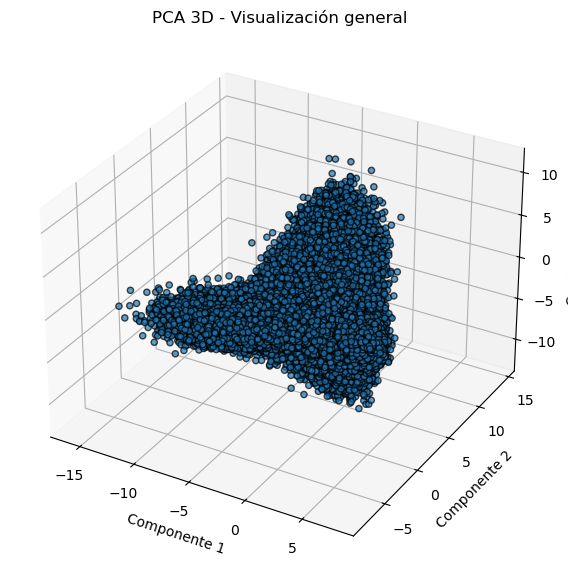

Varianza explicada por PCA: [0.00351833 0.00288585 0.00233487]


In [14]:
visualizar_PCA_3D(X_tfidf, sample_frac=1)

Distribución de las etiquetas de polaridad:

Etiqueta 1: 5441 instancias
Etiqueta 2: 5496 instancias
Etiqueta 3: 15519 instancias
Etiqueta 4: 45034 instancias
Etiqueta 5: 136561 instancias


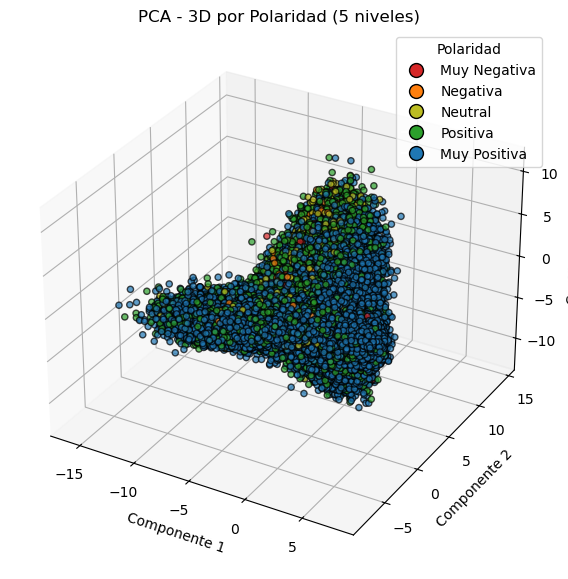

Varianza explicada por PCA: [0.00351833 0.00288585 0.00233487]


In [17]:
visualizar_PCA_polaridad(X_tfidf, Data, sample_frac=1)

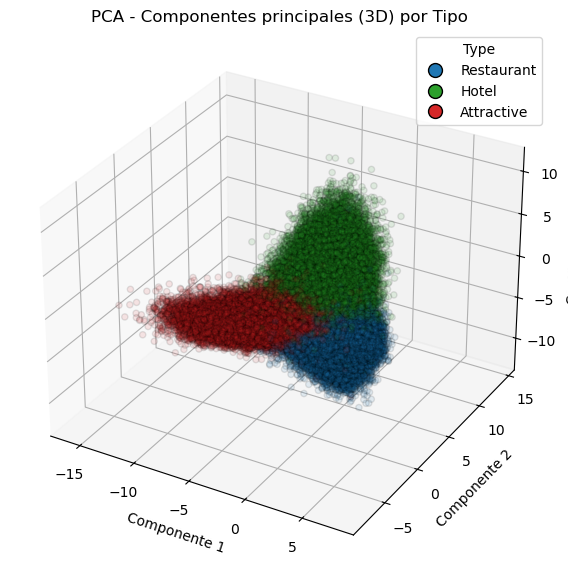

Varianza explicada por PCA: [0.00351833 0.00288585 0.00233487]


In [33]:
visualizar_PCA_tipo(X_tfidf, Data, sample_frac=1)

### Veamos PCA con BoW

In [ ]:
X_Bow, vectorizer = Representacion_BoW(Data)
BoW_dense =X_Bow.toarray()

aplicar_PCA(BoW_dense, Data)

In [ ]:
aplicar_PCA_por_tipo(BoW_dense, Data)

### Veamos PCA con Word2Vec

In [54]:
#Representacion_word2vec_promedio(Data, vector_size=100, window=2, min_count=3, sg=1, epochs=10)
X_word2vec, modelow2v =  Representacion_word2vec_promedio(Data, vector_size=100, window=2, min_count=3, sg=1, epochs=10)

In [ ]:
visualizar_PCA_3D(X_word2vec, sample_frac=1)

Distribución de las etiquetas de polaridad:

Etiqueta 1: 5441 instancias
Etiqueta 2: 5496 instancias
Etiqueta 3: 15519 instancias
Etiqueta 4: 45034 instancias
Etiqueta 5: 136561 instancias


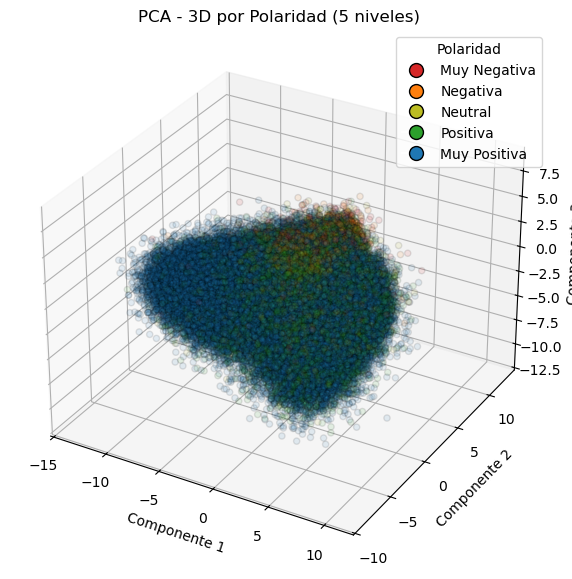

Varianza explicada por PCA: [0.1606698  0.07735859 0.06152923]


In [55]:
visualizar_PCA_polaridad(X_word2vec, Data, sample_frac=1)

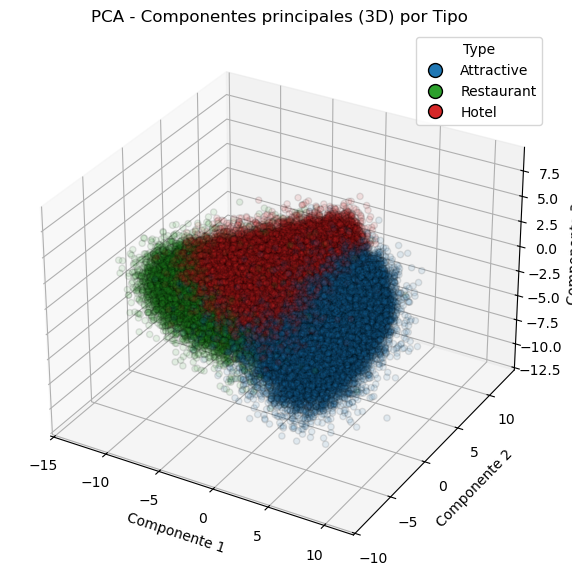

Varianza explicada por PCA: [0.1606698  0.07735859 0.06152923]


In [56]:
#X_word2vec, modelow2v =  Representacion_word2vec_promedio(Data, vector_size=100, window=3, min_count=5, sg=0, epochs=10)
visualizar_PCA_tipo(X_word2vec, Data, sample_frac=1)

### Veamos PCA con Doc2Vec

Matriz Doc2Vec generada con forma: (208051, 100)


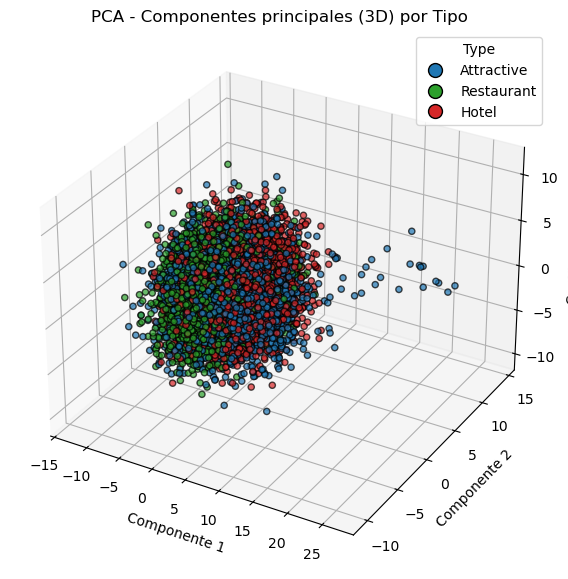

Varianza explicada por PCA: [0.09112009 0.06409065 0.05959937]


In [37]:
X_doc2vec, modelo_doc2vec = obtener_doc2vec(Data)
aplicar_PCA_por_tipo(X_doc2vec, Data)

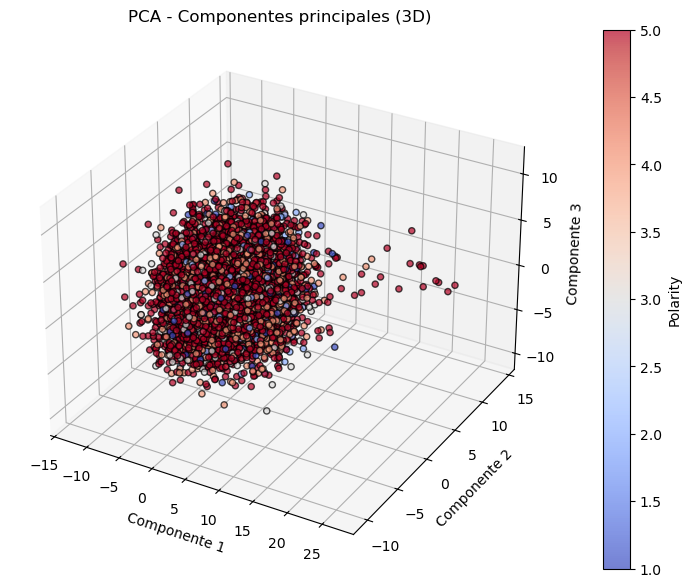

Varianza explicada por PCA: [0.09112009 0.06409065 0.05959937]


In [38]:
aplicar_PCA(X_doc2vec, Data)

### Veamos PCA con BERT

In [ ]:
X_bert = Representacion_BERT_optimizado(Data, batch_size=32)

In [ ]:
visualizar_PCA_3D(X_bert, sample_frac=1)

### Veamos PCA con FastText

In [58]:
#obtener_fasttext_promedio(Data, vector_size=100, window=2, min_count=5, sg=1, epochs=10)
X_fasttext, modelo_fasttext = obtener_fasttext_promedio(Data, vector_size=100, window=2, min_count=3, sg=1, epochs=10)

Matriz FastText generada con forma: (208051, 100)


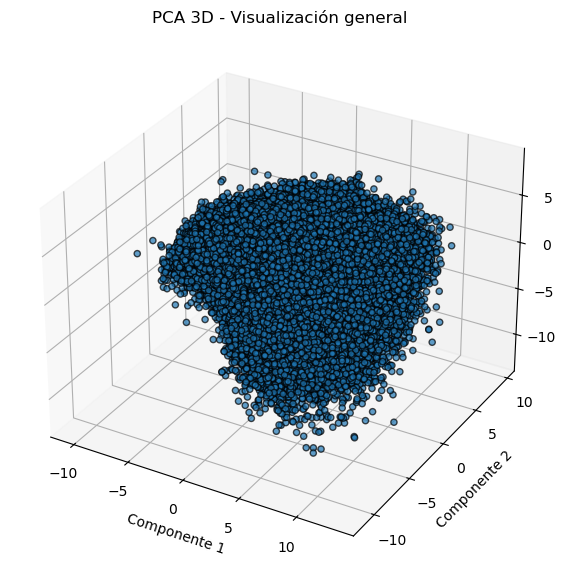

Varianza explicada por PCA: [0.15792073 0.07318037 0.06014084]


In [61]:
visualizar_PCA_3D(X_fasttext, sample_frac=1)

Distribución de las etiquetas de polaridad:

Etiqueta 1: 5441 instancias
Etiqueta 2: 5496 instancias
Etiqueta 3: 15519 instancias
Etiqueta 4: 45034 instancias
Etiqueta 5: 136561 instancias


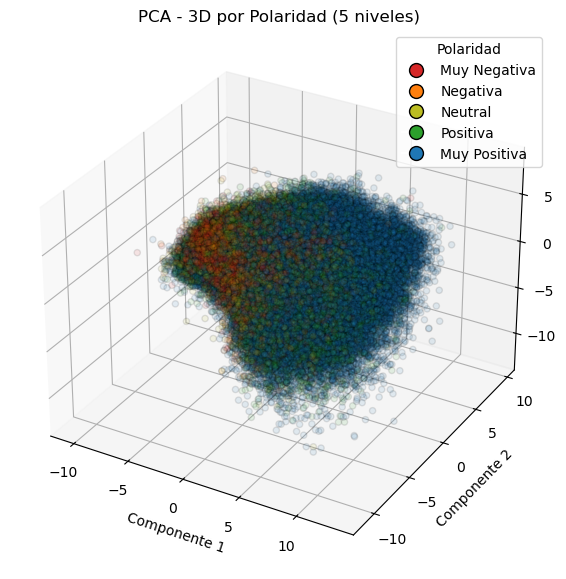

Varianza explicada por PCA: [0.15791889 0.0731798  0.06014012]


In [59]:
visualizar_PCA_polaridad(X_fasttext, Data, sample_frac=1)

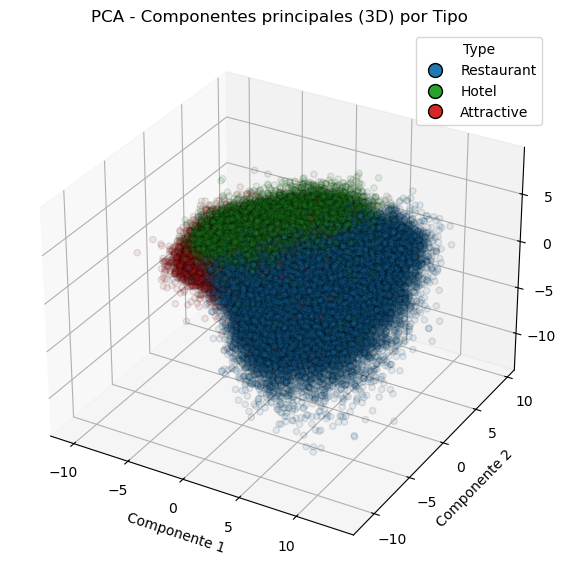

Varianza explicada por PCA: [0.15791726 0.0731805  0.06013965]


In [60]:
visualizar_PCA_tipo(X_fasttext, Data, sample_frac=1)

In [ ]:
from sklearn.manifold import TSNE
def aplicar_tSNE(X, Data):
    """
    Aplica t-SNE para reducir la dimensionalidad de los datos a 2 dimensiones
    y visualiza el resultado usando 'Polarity' como color.
    """
    # Tamaño de la muestra
    sample_size = int(X.shape[0] * 0.1)
    
    if issparse(X):
        X_sample = X[:sample_size]
        polarity_sample = Data['Polarity'].iloc[:sample_size]
    else:
        sampled_indices = np.random.choice(X.shape[0], sample_size, replace=False)
        X_sample = X[sampled_indices]
        polarity_sample = Data['Polarity'].iloc[sampled_indices]

    # Normalizamos los datos
    scaler = StandardScaler(with_mean=False)  # No centrar si es dispersa
    X_scaled = scaler.fit_transform(X_sample)

    # Reducimos dimensionalidad con PCA antes de t-SNE
    pca = PCA(n_components=min(50, X_scaled.shape[1]))  # Cuida que n_components no exceda features
    X_pca = pca.fit_transform(X_scaled)

    # Aplicamos t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_pca)

    # Visualización
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                          c=polarity_sample, cmap='coolwarm', edgecolor='k', alpha=0.6)
    plt.title('t-SNE de los datos reducidos (Coloreado por Polarity)')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.colorbar(scatter, label='Polarity')
    plt.show()



c:\Users\uzgre\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\uzgre\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\uzgre\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\uzgre\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\uzgre\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _wina

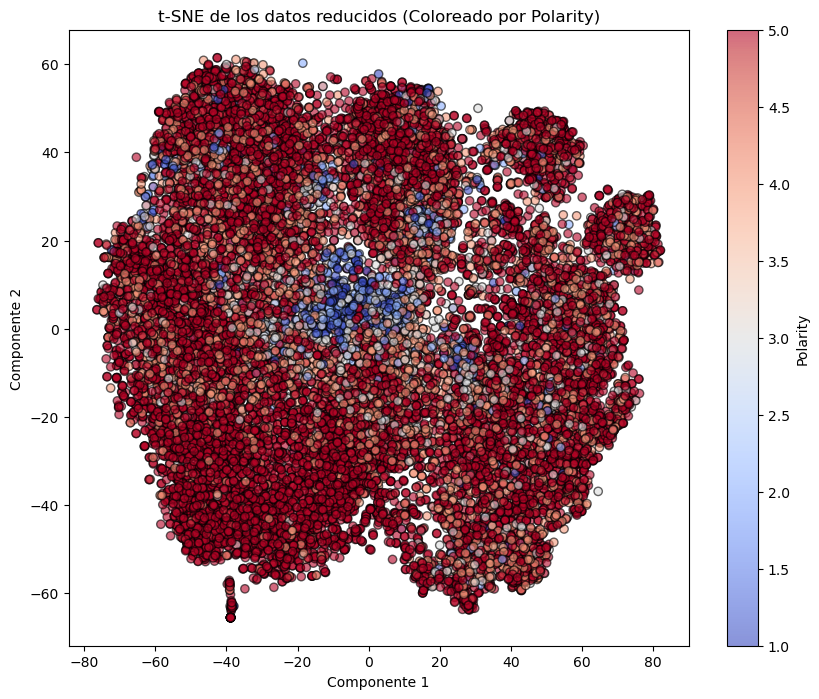

In [64]:
aplicar_tSNE(X_word2vec, Data)
